In [6]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
urls = {
    "Fed_rate" : 'https://clob.polymarket.com/prices-history?market=87769991026114894163580777793845523168226980076553814689875238288185044414090&interval=max',
    "ETH_ATH" : 'https://clob.polymarket.com/prices-history?market=58189491556125666756381190843159859466918849062932749642733305810000646541219&interval=max',
    "SOL_ATH" : 'https://clob.polymarket.com/prices-history?market=13712414994647718681852050208315800469280653953019389350409753383470842470352&interval=max',
    "BTC_dip" : 'https://clob.polymarket.com/prices-history?market=38880531420851293294206408195662191626124315938743706007994446557347938404169&interval=max',
    "BTC_price" : 'https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=usd&days=31'
}

In [7]:
def load_polymarket_data(url, name):
    r = requests.get(url)
    data = r.json()["history"]
    df = pd.DataFrame(data)
    df["date"] = pd.to_datetime(df["t"], unit="s").dt.date
    df = df.groupby("date")["p"].mean().reset_index()
    df = df.rename(columns={"p": name})
    return df

def load_coingecko_data(url, name):
    r = requests.get(url)
    data = r.json()["prices"]
    df = pd.DataFrame(data, columns=["timestamp", "price"])
    df["date"] = pd.to_datetime(df["timestamp"], unit="ms").dt.date
    df = df.groupby("date")["price"].mean().reset_index()
    df = df.rename(columns={"price": name})
    return df

df_dict = {
    "Fed_rate": load_polymarket_data(urls["Fed_rate"], "Fed_rate"),
    "ETH_ATH": load_polymarket_data(urls["ETH_ATH"], "ETH_ATH"),
    "SOL_ATH": load_polymarket_data(urls["SOL_ATH"], "SOL_ATH"),
    "BTC_dip": load_polymarket_data(urls["BTC_dip"], "BTC_dip"),
    "BTC_price": load_coingecko_data(urls["BTC_price"], "BTC_price")
}

df_merged = df_dict["BTC_price"]
for name, df in df_dict.items():
    if name != "BTC_price":
        df_merged = pd.merge(df_merged, df, on="date", how="outer")
df_merged = df_merged.sort_values("date").reset_index(drop=True)
df_merged.head()

,date,BTC_price,Fed_rate,ETH_ATH,SOL_ATH,BTC_dip
0,2025-10-03,122558.705910,0.745000,0.725500,0.557000,0.281000
1,2025-10-04,122144.454146,0.745000,0.708819,0.521007,0.287500
2,2025-10-05,123429.655443,0.745000,0.719618,0.529826,0.250972
3,2025-10-06,124424.452493,0.745000,0.757882,0.567465,0.247292
4,2025-10-07,123418.043317,0.719618,0.785312,0.517292,0.249271


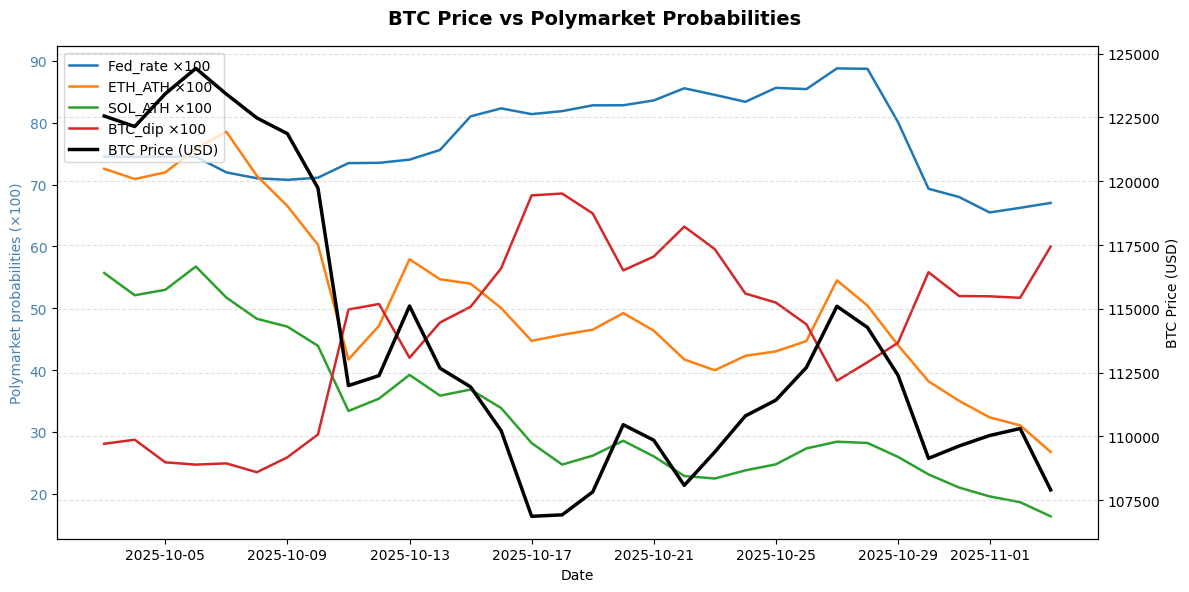

In [8]:
cols = ["Fed_rate", "ETH_ATH", "SOL_ATH", "BTC_dip"]
df_scaled = df_merged.copy()
df_scaled[cols] = df_scaled[cols] * 100
fig, ax1 = plt.subplots(figsize=(12, 6))
for col in cols:
    ax1.plot(df_scaled["date"], df_scaled[col], label=f"{col} ×100", linewidth=1.8)

ax1.set_xlabel("Date")
ax1.set_ylabel("Polymarket probabilities (×100)", color="steelblue")
ax1.tick_params(axis="y", labelcolor="steelblue")

ax2 = ax1.twinx()
ax2.plot(df_scaled["date"], df_scaled["BTC_price"], color="black", label="BTC Price (USD)", linewidth=2.5)
ax2.set_ylabel("BTC Price (USD)", color="black")
ax2.tick_params(axis="y", labelcolor="black")

fig.suptitle("BTC Price vs Polymarket Probabilities", fontsize=14, fontweight="bold")
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [9]:
corr = df_merged.rename(columns={
    'Fed_rate': 'Fed Decision in Dec',
    'ETH_ATH': 'ETH ATH in Dec',
    'SOL_ATH': 'SOL ATH 2026',
    'BTC_dip': 'BTC Dip before 2026',
    'BTC_price': 'BTC daily Price'
}).select_dtypes(include=['float', 'int']).corr()
corr


,BTC daily Price,Fed Decision in Dec,ETH ATH in Dec,SOL ATH 2026,BTC Dip before 2026
BTC daily Price,1.000000,-0.283545,0.907246,0.922236,-0.976368
Fed Decision in Dec,-0.283545,1.000000,-0.045880,-0.216305,0.322048
ETH ATH in Dec,0.907246,-0.045880,1.000000,0.961147,-0.826542
SOL ATH 2026,0.922236,-0.216305,0.961147,1.000000,-0.841759
BTC Dip before 2026,-0.976368,0.322048,-0.826542,-0.841759,1.000000


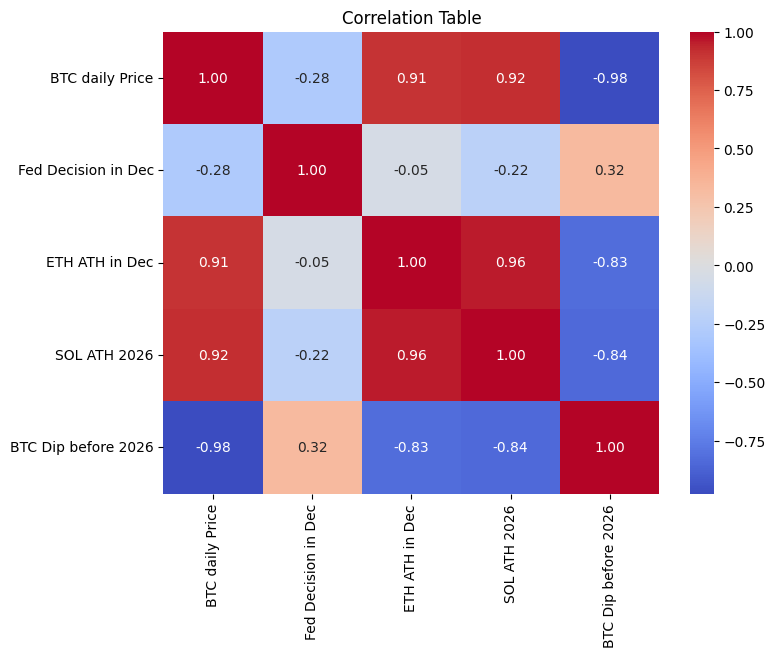

In [10]:
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Table")
plt.show()